In [1]:
import torch
import matplotlib.pyplot as plt
from monai.networks.nets import SegResNet
import json 
from monai.transforms import (Compose,
                            LoadImaged,
                            NormalizeIntensityd,
                            Activations, 
                            AsDiscrete,
                            MapTransform)
from monai.data import CacheDataset
import numpy as np


In [3]:
class PreprocessDatad(MapTransform):
    def __init__(self, keys, divider):
        super().__init__(keys)
        self.divider = divider
        
    def __call__(self, x):
        for key in self.keys:
            x[key] = x[key].unsqueeze(0)
            remainder = x[key].shape[3] % self.divider
            if remainder != 0:
                _,H,W,_ = x[key].shape # 1,H,W,D
                x[key] = torch.cat([x[key],torch.zeros(1,H,W,self.divider - remainder)],dim=3)
        return x

In [4]:
class ConcatTwoChanneld(MapTransform):
    def __init__(self,keys):
        super().__init__(keys)
        
    def __call__(self, x):
        adc = x['image']
        z_adc = x['zmap']
        x['image'] = torch.cat([adc,z_adc],dim=0)
        x['zmap'] = x['image']
        return x

In [5]:
class Permuted(MapTransform):
    def __init__(self,keys):
        super().__init__(keys)
        
    def __call__(self, x):
        for key in self.keys:
            x[key] = x[key].permute(0,3,1,2) # shape C,D,H,W
        return x

In [6]:
class ReciprocalTransform_Concatd(MapTransform):
    def __init__(self,keys,power):
        super().__init__(keys)
        self.power = power

    def __call__(self, x):
        adc = x['image']
        z_adc = x['zmap']
        D = adc.shape[3]
        for d in range(D):
            min_data = torch.min(z_adc[:,:,:,d]).item()
            adc[:,:,:,d] = adc[:,:,:,d] / (1 + abs(min_data) + z_adc[:,:,:,d])**(self.power)

        x['image'] = torch.cat([x['image'],x['zmap'],adc],dim=0)
        x['zmap'] = x['image']
        return x

In [7]:
def RemovePadding(batch_data,original_list,index):
    batch_data = batch_data[:,:,:original_list[index],:,:] # (N,C,D,H,W)
    return batch_data     

In [8]:
class Unsqueezed(MapTransform):
    def __init__(self,keys):
        super().__init__(keys)
        
    def __call__(self, x):
        for key in self.keys:
            x[key] = x[key].unsqueeze(0) 
        return x


In [10]:
val_transform = Compose(
        [LoadImaged(keys=["image","zmap","label"], reader = 'ITKReader'),
        PreprocessDatad(keys=["image","zmap","label"], divider=8),
        ReciprocalTransform_Concatd(keys=["image","zmap"], power=1.5),
        # ConcatTwoChanneld(keys=["image","zmap"]),
        NormalizeIntensityd(keys=["image","zmap"], nonzero=True, channel_wise=True),
        Permuted(keys=["image","zmap", "label"]),
        ]
)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_path = './bonbid_dataset_monai/dataset.json'

post_trans = Compose([Activations(sigmoid=True),
                      AsDiscrete(threshold=0.5)])

In [12]:
with open(data_path,'r') as js_file:
    json_object = json.load(js_file)

with open('./work_dir/15_09_2023_10_53_51_SegResNet_val_index.json','r') as val_json_file:
    val_dict = json.load(val_json_file)

val_idx = val_dict['fold_1']


with open('./original_size/15_09_2023_10_53_51_SegResNet_ori_size.json','r') as ori_file:
    ori_dict = json.load(ori_file)

model = SegResNet(spatial_dims=3,init_filters=32,in_channels=3,out_channels=1,
                      dropout_prob=0.2,num_groups=8,norm_name='GROUP',upsample_mode='deconv').to(device)


val_dataset = CacheDataset(json_object['training'],transform=val_transform)

val_dataset_subset = torch.utils.data.Subset(val_dataset,val_idx)
val_loader = torch.utils.data.DataLoader(val_dataset_subset, batch_size=1,num_workers=0,shuffle=False)

val_list = list(item for item in val_loader)

Loading dataset: 100%|██████████| 85/85 [00:07<00:00, 11.35it/s]


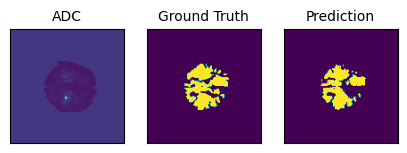

In [58]:
model = SegResNet(spatial_dims=3,init_filters=32,in_channels=3,out_channels=1,
                      dropout_prob=0.2,num_groups=8,norm_name='GROUP',upsample_mode='deconv').to(device)
model.load_state_dict(torch.load('./best_checkpoints/SegResNet_best_checkpoint_fold_1_15_09_2023_10_53_51.pth'))

model.eval()
img_no = 10
person_no = 2
with torch.no_grad():
    input = val_list[person_no]['image'].to(device)
    label = val_list[person_no]['label']
    val_output = model(input)

    input = RemovePadding(input,ori_dict['size'],person_no)
    label = RemovePadding(label,ori_dict['size'],person_no)
    val_output = RemovePadding(val_output,ori_dict['size'],person_no)
    output = post_trans(val_output)

    for i in range(10):
        plt.subplot(10,3,3*i+1)
        plt.title('ADC')
        plt.imshow(input[0,0,img_no + i, :, :].detach().cpu())
        plt.subplot(10,3,3*i+2)
        plt.title('Ground Truth')
        plt.imshow(label[0,0,img_no+ i, :, :].detach().cpu())
        plt.subplot(10,3,3*i+3)
        plt.title('Prediction')
        plt.imshow(output[0,0,img_no + i, :, :].detach().cpu())
    plt.show()